In [1]:
import os
import random
import shutil
import glob as gb
from tqdm import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch

from tensorflow.keras.preprocessing.image import load_img,img_to_array 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D,Flatten, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

from keras import Model
from keras.layers import Input

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2, l1

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Activation,
    Concatenate, RandomFlip, RandomRotation, RandomZoom,
    RandomTranslation, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import GaussianNoise, LayerNormalization

In [3]:
def visualize_random_images(male_folder, female_folder, num_images=5):
    male_images = os.listdir(male_folder)
    female_images = os.listdir(female_folder)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i in range(num_images):
        male_image_path = os.path.join(male_folder, random.choice(male_images))
        female_image_path = os.path.join(female_folder, random.choice(female_images))

        male_img = plt.imread(male_image_path)
        female_img = plt.imread(female_image_path)

        axes[0, i].imshow(male_img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Male')

        axes[1, i].imshow(female_img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Female')

    plt.show()

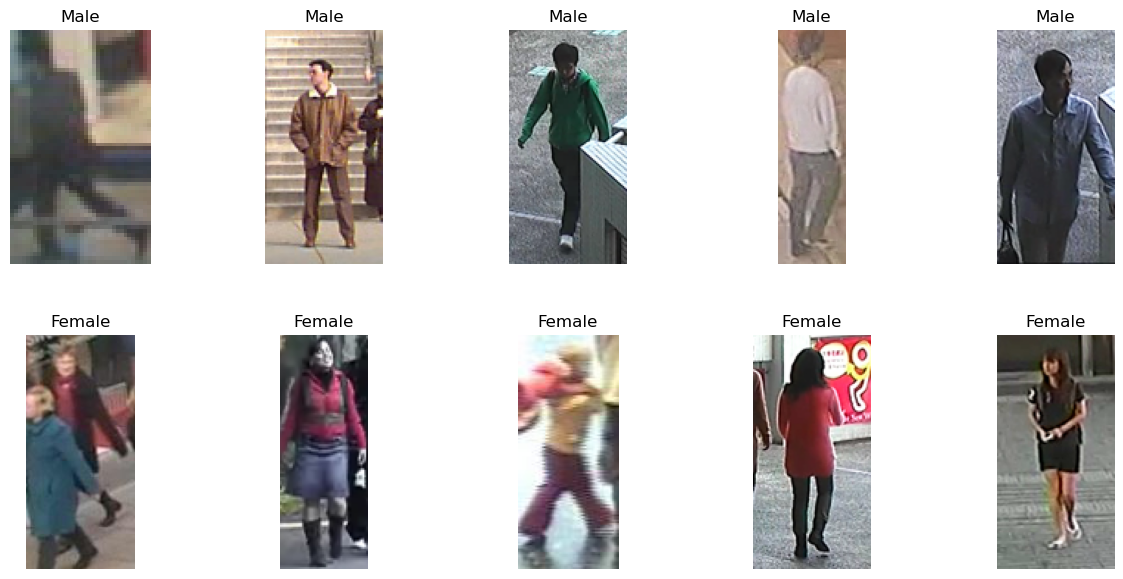

In [4]:
male_folder = (r"C:\SIH Project\Dataset\archive (2)\CCTV Gender Classifier Dataset\MALE")
female_folder = (r"C:\SIH Project\Dataset\archive (2)\CCTV Gender Classifier Dataset\FEMALE")
visualize_random_images(male_folder, female_folder)

In [5]:
num_male_images = len(os.listdir(male_folder))
num_female_images = len(os.listdir(female_folder))

print(f"Total number of male images: {num_male_images}")
print(f"Total number of female images: {num_female_images}")

Total number of male images: 9626
Total number of female images: 9759


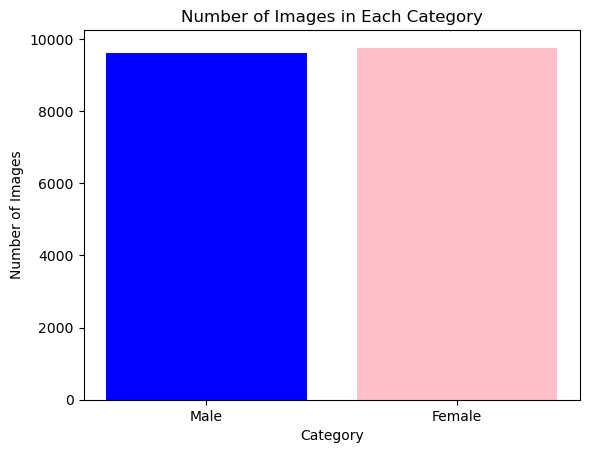

In [6]:
# Create bar plot
categories = ['Male', 'Female']
num_images = [num_male_images, num_female_images]

plt.bar(categories, num_images, color=['blue', 'pink'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

In [7]:
DataPath = (r"C:\SIH Project\Dataset\archive (2)\CCTV Gender Classifier Dataset")

labels2int={"MALE":0,"FEMALE":1}
int2labels={0:"MALE",1:"FEMALE"}

Data = []
Classes = []

# Iterate through each folder in DataPath
for folder in os.listdir(DataPath):
    print(folder)
    
    # Construct the full path to the folder
    folder_path = os.path.join(DataPath, folder)
    
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    print(f"Data found {len(files)} in {folder}")
    
    # Iterate through each file in the folder
    for file in files:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Load the image, resize it, and convert it to an array
        img = load_img(file_path, target_size=(200, 100))
        img_array = img_to_array(img)
        
        # Preprocess the image array
        img_array = preprocess_input(img_array)
        
        # Append the preprocessed image array to the Data list
        Data.append(img_array)
        
        # Append the label to the Classes list based on the folder name
        Classes.append(labels2int[folder])

FEMALE
Data found 9759 in FEMALE
MALE
Data found 9626 in MALE


In [8]:
print("Length of Classes before binarization:", len(Classes))

Length of Classes before binarization: 19385


In [9]:
lb = LabelBinarizer()
Classes = lb.fit_transform(Classes)
Classes = to_categorical(Classes)
print("Shape of Classes after binarization and conversion:", Classes.shape)

Shape of Classes after binarization and conversion: (19385, 2)


In [10]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
trainx,testx,trainy,testy = train_test_split(Data,Classes,test_size=0.20,stratify=Classes,
                                             random_state=42,shuffle=True)
print("Shape of training data (trainx):", trainx.shape)
print("Shape of testing data (testx):", testx.shape)
print("Shape of training labels (trainy):", trainy.shape)
print("Shape of testing labels (testy):", testy.shape)

Shape of training data (trainx): (15508, 200, 100, 3)
Shape of testing data (testx): (3877, 200, 100, 3)
Shape of training labels (trainy): (15508, 2)
Shape of testing labels (testy): (3877, 2)


In [11]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
# Split data into training and testing sets (80% train, 20% test)
Data_train, Data_test, Classes_train, Classes_test = train_test_split(Data, Classes, test_size=0.2, random_state=42)

# Split training data into training and validation sets (80% train, 20% validation)
Data_train, Data_val, Classes_train, Classes_val = train_test_split(Data_train, Classes_train, test_size=0.2, random_state=42)

print("Shape of training data (Data_train):", Data_train.shape)
print("Shape of Validation data (Data_val):", Data_val.shape)
print("Shape of testing data (Data_test):", Data_test.shape)
print('=============================================================')
print("Shape of training labels (Classes_train):", Classes_train.shape)
print("Shape of Validation labels (Classes_test):", Classes_val.shape)
print("Shape of testing labels (Classes_test):", Classes_test.shape)

Shape of training data (Data_train): (12406, 200, 100, 3)
Shape of Validation data (Data_val): (3102, 200, 100, 3)
Shape of testing data (Data_test): (3877, 200, 100, 3)
Shape of training labels (Classes_train): (12406, 2)
Shape of Validation labels (Classes_test): (3102, 2)
Shape of testing labels (Classes_test): (3877, 2)


In [12]:
print("Training data shape:", Data_train.shape)
print("Training labels shape:", Classes_train.shape)
print("Memory usage of training data (GB):", Data_train.nbytes / 1e9)

Training data shape: (12406, 200, 100, 3)
Training labels shape: (12406, 2)
Memory usage of training data (GB): 2.97744


In [13]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Configure GPU to use mixed precision
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        
        # Configure memory growth
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
            
        # Set memory limit to 5GB (leaving some buffer)
        tf.config.set_logical_device_configuration(
            physical_devices[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])
            
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU, compute capability 8.6


In [14]:
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation,
    Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [16]:
def resnet50_modelarch():
    lr = 1e-4
    epochs = 50
    
    # Simplified data augmentation with available layers
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.15),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1)
    ], name="data_augmentation")
    
    inputs = Input(shape=(200,100,3))
    x = data_augmentation(inputs)
    
    # Base model with gradient clipping
    basemodel = ResNet50(include_top=False, input_tensor=x, weights='imagenet')
    
    # Progressive layer unfreezing
    for layer in basemodel.layers[:-30]:
        layer.trainable = False
    
    headmodel = basemodel.output
    headmodel = GlobalAveragePooling2D()(headmodel)
    
    # Simplified dense layers with stronger regularization
    headmodel = Dense(256, activation="relu",
                     kernel_regularizer=l2(0.02))(headmodel)
    headmodel = BatchNormalization()(headmodel)
    headmodel = Dropout(0.6)(headmodel)
    
    headmodel = Dense(128, activation="relu",
                     kernel_regularizer=l2(0.02))(headmodel)
    headmodel = BatchNormalization()(headmodel)
    headmodel = Dropout(0.6)(headmodel)
    
    headmodel = Dense(2, activation='softmax')(headmodel)
    
    model = Model(inputs=inputs, outputs=headmodel)
    
    # Cosine decay learning rate schedule
    initial_learning_rate = lr
    decay_steps = epochs * (12500 // 16)
    lr_schedule = CosineDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        alpha=0.1
    )
    
    opt = Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        clipnorm=1.0,
        amsgrad=True
    )
    
    model.compile(
        loss="binary_crossentropy", 
        optimizer=opt,
        metrics=["accuracy"]
    )
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    return model, callbacks, epochs

In [17]:
# Usage
model, callbacks, epochs = resnet50_modelarch()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 100, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 200, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 106, 3)  0           data_augmentation[0][0]          
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 50, 64)  9472        conv1_pad[0][0]                  
______________________________________________________________________________________________

In [ ]:
# Training command
history = model.fit(
    Data_train, 
    Classes_train,
    batch_size=16,
    validation_data=(Data_val, Classes_val),
    epochs=epochs,
    callbacks=callbacks,
    workers=1,
    max_queue_size=2,
    use_multiprocessing=False
)

Epoch 1/50
776/776 [==============================] - 53s 50ms/step - loss: 10.8564 - accuracy: 0.6336 - val_loss: 8.1285 - val_accuracy: 0.7785

Epoch 00001: val_accuracy improved from -inf to 0.77853, saving model to best_model.h5


C:\Users\ybadr\anaconda3\Anaconda\envs\Softcomputing\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
776/776 [==============================] - 37s 48ms/step - loss: 6.0826 - accuracy: 0.7123 - val_loss: 4.0600 - val_accuracy: 0.7930

Epoch 00002: val_accuracy improved from 0.77853 to 0.79304, saving model to best_model.h5
Epoch 3/50
776/776 [==============================] - 37s 48ms/step - loss: 3.0253 - accuracy: 0.7449 - val_loss: 2.0362 - val_accuracy: 0.8108

Epoch 00003: val_accuracy improved from 0.79304 to 0.81077, saving model to best_model.h5
Epoch 4/50
776/776 [==============================] - 37s 48ms/step - loss: 1.6389 - accuracy: 0.7772 - val_loss: 1.1897 - val_accuracy: 0.8092

Epoch 00004: val_accuracy did not improve from 0.81077
Epoch 5/50
776/776 [==============================] - 37s 47ms/step - loss: 1.0375 - accuracy: 0.7902 - val_loss: 0.8044 - val_accuracy: 0.8298

Epoch 00005: val_accuracy improved from 0.81077 to 0.82979, saving model to best_model.h5
Epoch 6/50
776/776 [==============================] - 37s 47ms/step - loss: 0.7679 - accuracy: 

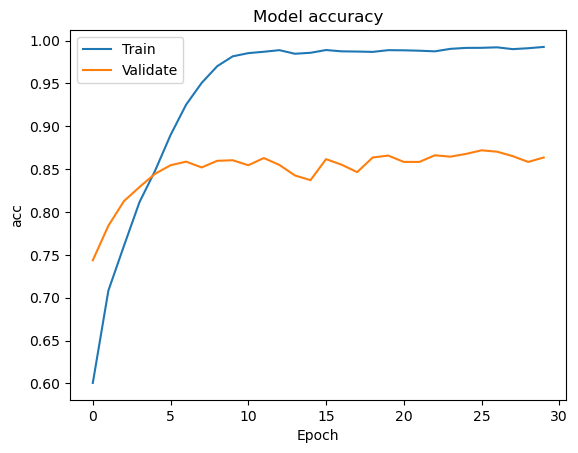

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

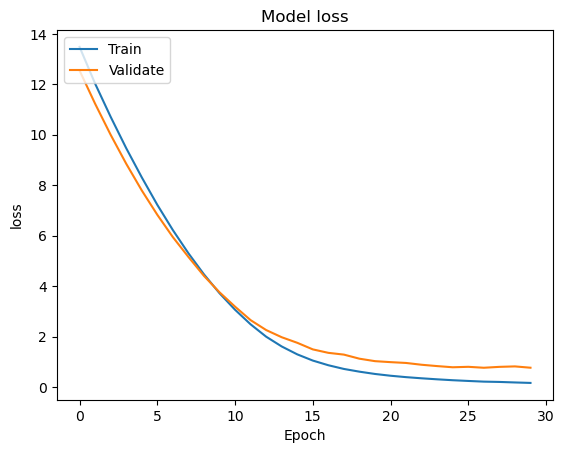

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show() 

In [24]:
scores = model.evaluate(Data_test,Classes_test, verbose=1)
print("ResNet50 Score:",scores[1])

122/122 [==============================] - 5s 33ms/step - loss: 13.2696 - accuracy: 0.4893
ResNet50 Score: 0.4892958402633667


In [25]:
predIdxs = model.predict(Data_test,batch_size=32) 
predIdxs=np.argmax(predIdxs,axis=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
testy_res = Classes_test.argmax(axis=1)
CR = classification_report(testy_res, predIdxs)
print(CR)

In [ ]:
# Get predictions for the test set
predictions = model.predict(Data_test)

# Convert predictions to class labels (0 for male, 1 for female)
predicted_labels = np.argmax(predictions, axis=1)

# Compare predicted labels with true labels
correct_predictions = np.sum(predicted_labels == np.argmax(Classes_test, axis=1))
total_samples = len(Classes_test)

# Calculate accuracy
accuracy = correct_predictions / total_samples
print("Test Accuracy:", accuracy)

In [ ]:
class_names=['MALE','FEMALE']

In [ ]:
import random
def plot_prediction(Data_test, Classes_test, n_images, class_names):
    """
    Test the model on random predictions and plot the results.
    
    Args:
        Data_test (numpy array): The test images data.
        Classes_test (numpy array): The true labels for the test images.
        n_images (int): Number of images to plot.
        class_names (list): List of class names.
    """
    # Get the total number of test images
    num_images = len(Data_test)
    
    # Randomly select indices for the images to plot
    random_indices = random.sample(range(num_images), n_images)
    
    # Make predictions on the selected test data
    predictions = np.argmax(model.predict(Data_test[random_indices]), axis=1)
    
    # Plot the randomly selected images along with their true labels and predictions
    plt.figure(figsize=(14, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 3, i+1)
        plt.imshow(Data_test[idx])
        if predictions[i] == np.argmax(Classes_test[idx]):
            title_color = 'g'  # green color for correct predictions
        else:
            title_color = 'r'  # red color for incorrect predictions
        plt.title(class_names[np.argmax(Classes_test[idx])], color=title_color)
        plt.axis('off')
        
    plt.show()

In [ ]:
plot_prediction(Data_test, Classes_test, n_images=6, class_names=class_names)

In [ ]:
model.save("GenderClassification.h5")